In [1]:
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm

@jit(nopython=True)
def costh2N(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(lat)*cos(wt) - sin(th_X)*sin(phi_X)*sin(lat)*sin(wt) + costh_X*cos(lat))**2

@jit(nopython=True)
def costh2W(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(wt) - sin(th_X)*sin(phi_X)*cos(wt))**2

@jit(nopython=True)
def costh2Z(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*cos(lat)*cos(wt) + sin(th_X)*sin(phi_X)*cos(lat)*sin(wt) + costh_X*sin(lat))**2

@jit(nopython=True)
def costh2ZW(t,costh_X,phi_X,lat):
    return 1 - costh2N(t,costh_X,phi_X,lat)

@jit(nopython=True)
def costh2ZN(t,costh_X,phi_X,lat):
    return 1 - costh2W(t,costh_X,phi_X,lat)

@jit(nopython=True)
def costh2NW(t,costh_X,phi_X,lat):
    return 1 - costh2Z(t,costh_X,phi_X,lat)

def costh_T_05(fcosth2,lat,Tmax,nt=1000,ngen=100000):
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    
    T = linspace(0,Tmax,nt+1)

    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i],costh_X,phi_X,lat)

    c_av = cumtrapz(c1t,T)/T[1:]
    
    C_05 = zeros(shape=nt)
    for i in range(0,nt):
        sort_c = sort(c_av[:,i])
        C_05[i] = sort_c[int(0.05*ngen)]
    
    return T[1:],C_05

nlats = 10
lats = linspace(35,55,nlats)
nt = 1000
CN = zeros(shape=(nlats,nt))
for i in tqdm(range(0,nlats)):
    T,CN[i,:] = costh_T_05(costh2N,lats[i],3,nt=nt)

T,CW = costh_T_05(costh2W,45,3)

100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


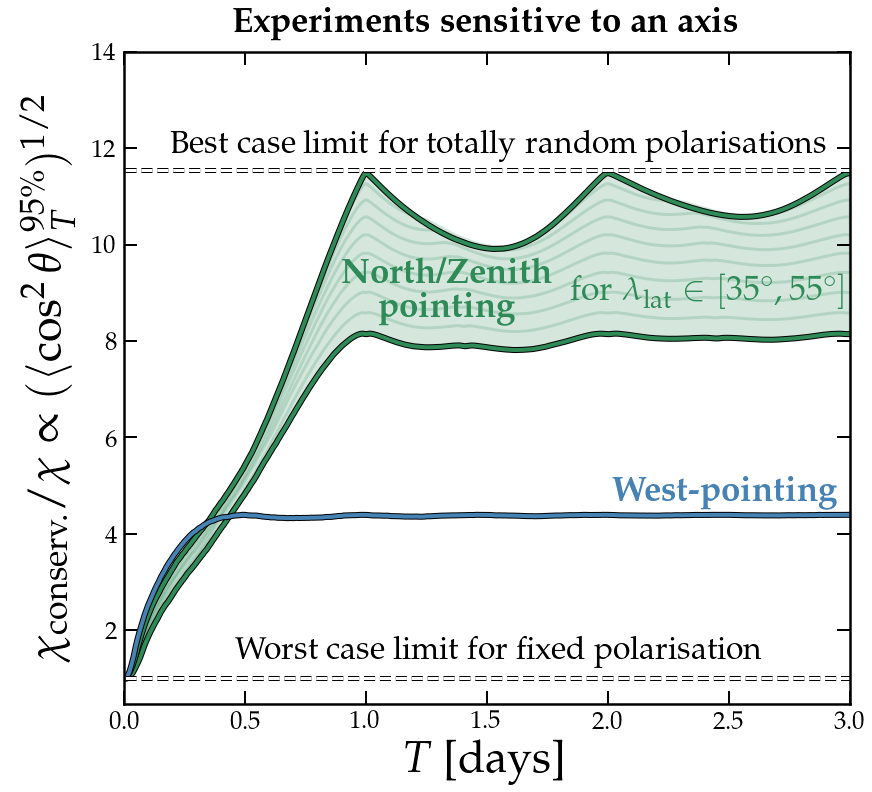

In [11]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe

pek=[pe.Stroke(linewidth=6, foreground='k',alpha=1), pe.Normal()]
pek1=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

fig,ax = MySquarePlot(r'$T$ [days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{95\%}_T)^{1/2}$')

plt.fill_between(T,sqrt(CN[0,:]*T)/sqrt(0.0025*T),y2=sqrt(CN[-1,:]*T)/sqrt(0.0025*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CN[i,:]*T)/sqrt(0.0025*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CN[0,:]*T)/sqrt(0.0025*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CN[-1,:]*T)/sqrt(0.0025*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CW*T)/sqrt(0.0025*T),'-',color='steelblue',lw=4,path_effects=pek)


plt.plot(T,sqrt(0.3333*T)/sqrt(0.0025*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=14)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,11.9,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.4,'Worst case limit for fixed polarisation',ha='center',fontsize=32)

plt.text(2.95,4.7,r'{\bf West-pointing}',color='steelblue',fontsize=35,ha='right')
plt.text(1.34,9.2,r'{\bf North/Zenith}',fontsize=35,color='seagreen',ha='center')
plt.text(1.34,8.5,r'{\bf pointing}',fontsize=35,color='seagreen',ha='center')

plt.text(2.99,8.7,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')

plt.title(r'{\bf Experiments sensitive to an axis}',fontsize=35,pad=20)
MySaveFig(fig,'Improvement_Axis')

In [3]:
nlats = 10
lats = linspace(35,55,nlats)
nt = 1000
CZW = zeros(shape=(nlats,nt))
for i in tqdm(range(0,nlats)):
    T,CZW[i,:] = costh_T_05(costh2ZW,lats[i],3,nt=nt)

T,CZN = costh_T_05(costh2ZN,45,3)

100%|██████████| 10/10 [02:26<00:00, 14.68s/it]


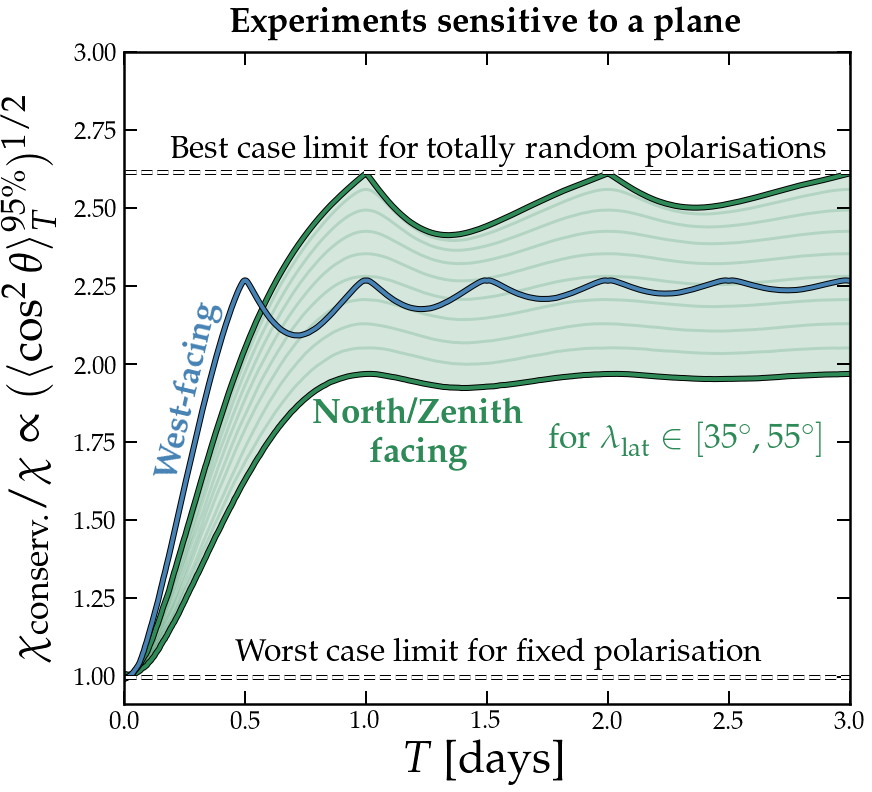

In [10]:
fig,ax = MySquarePlot(r'$T$ [days]',r'$\chi_{\rm conserv.}/\chi \propto (\langle\cos^2{\theta}\rangle^{95\%}_T)^{1/2}$')

plt.fill_between(T,sqrt(CZW[0,:]*T)/sqrt(0.0975*T),y2=sqrt(CZW[-1,:]*T)/sqrt(0.0975*T),lw=3,color='seagreen',alpha=0.2)
for i in range(0,nlats):
    plt.plot(T,sqrt(CZW[i,:]*T)/sqrt(0.0975*T),'-',lw=3,color='seagreen',alpha=0.2)
    
plt.plot(T,sqrt(CZW[0,:]*T)/sqrt(0.0975*T),'-',lw=4,color='seagreen',path_effects=pek)
plt.plot(T,sqrt(CZW[-1,:]*T)/sqrt(0.0975*T),'-',lw=4,color='seagreen',path_effects=pek)

    
plt.plot(T,sqrt(CZN*T)/sqrt(0.0975*T),'-',color='steelblue',lw=4,path_effects=pek)


plt.plot(T,sqrt(0.6666*T)/sqrt(0.0975*T),'w--',lw=3,path_effects=pek1)
plt.plot(T,0*T+1,'w--',lw=3,path_effects=pek1)

plt.xlim(right=T[-1],left=0)
plt.ylim(top=3)
plt.gcf().text(0.00,0.1,'--',color='w')


plt.text(1.55,2.66,'Best case limit for totally random polarisations',ha='center',fontsize=32)
plt.text(1.55,1.05,'Worst case limit for fixed polarisation',ha='center',fontsize=32)
plt.text(0.42,1.65,r'{\bf West-facing}',rotation=77,color='steelblue',fontsize=34,ha='right')
plt.text(1.22,1.81,r'{\bf North/Zenith}',fontsize=35,color='seagreen',ha='center')
plt.text(1.22,1.69,r'{\bf facing}',fontsize=35,color='seagreen',ha='center')
plt.text(2.9,1.71,r' for $\lambda_{\rm lat} \in [35^\circ,55^\circ]$',fontsize=34,color='seagreen',ha='right')


plt.title(r'{\bf Experiments sensitive to a plane}',fontsize=35,pad=20)

MySaveFig(fig,'Improvement_Plane')